## Multi-Asset Black-Scholes Model
This notebook uses the model `finmc.models.multi.BSMC` and shows how to
- create dataset for this model
- create a scatterplot of the two assets returns.

In [2]:
import numpy as np
from finmc.models.multi import BSMC
import matplotlib.pyplot as plt
np.set_printoptions(threshold=1000)

Create dataset for this model. See [Multi-Asset BS Model Documentation](https://finlib.github.io/finmc/models/bsm/) for explanation of model parameters.

In [3]:
# Covariance matrix with 50% correlation
cov = np.array(
    [
        [0.09, 0.03],
        [0.03, 0.04],
    ]
)
# Define Dataset with zero rate curve, and forward curve.
# use fewer paths, as we are interested in visualizing the distribution.
dataset = {
    "MC": {"PATHS": 1000, "TIMESTEP": 1 / 20, "SEED": 48},
    "BASE": "USD",
    "ASSETS": {
        "USD": ("ZERO_RATES", np.array([[2.0, 0.05]])),
        "NVDA": ("FORWARD", np.array([[0.0, 116.00], [2.0, 120.64]])),
        "INTC": ("FORWARD", np.array([[0.0, 21.84], [2.0, 22.70]])),
    },
    "BSM": {
        "ASSETS": ["NVDA", "INTC"],
        "COV": cov,
    },
}

### Distribution with different correlation

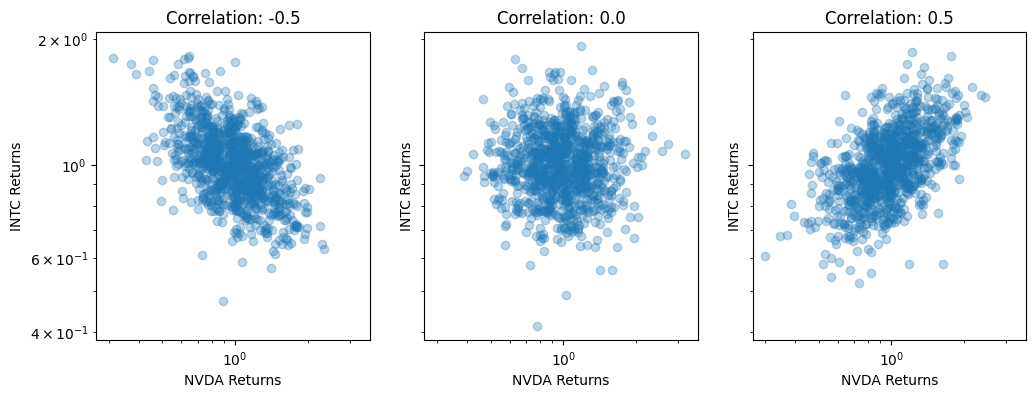

In [4]:
model = BSMC(dataset)
f, axes = plt.subplots(
    nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12, 4)
)
v1 = 0.3
v2 = 0.2

for rho, ax in zip([-0.5, 0.0, 0.5], axes):
    # Change correlation
    dataset["BSM"]["COV"] = np.array(
        [
            [v1 * v1, rho * v1 * v2],
            [rho * v1 * v2, v2 * v2],
        ]
    )
    # Get returns distribution
    model.reset()
    model.advance(1.0)
    nvda_returns = model.get_value("NVDA") / 116.00
    intc_returns = model.get_value("INTC") / 21.84

    # Plot
    ax.scatter(nvda_returns, intc_returns, alpha=0.3)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"Correlation: {rho}")
    ax.set_xlabel("NVDA Returns")
    ax.set_ylabel("INTC Returns")

In [5]:
# Covariance matrix
cov = np.array(
    [
        [0.09, 0.03],
        [0.03, 0.04],
    ]
)

# Complete dataset
dataset = {
    "MC": {
        "PATHS": 100_000,
        "TIMESTEP": 1 / 10,
        "SEED": 1,
    },
    "BASE": "USD",
    # assets with discounts and forwards for two years
    "ASSETS": {
        "USD": ("ZERO_RATES", np.array([[2.0, 0.05]])),
        "NVDA": ("FORWARD", np.array([[0.0, 116.00], [2.0, 120.64]])),
        "INTC": ("FORWARD", np.array([[0.0, 21.84], [2.0, 22.70]])),
    },
    "BSM": {
        "ASSETS": ["NVDA", "INTC"],
        "COV": cov,
    },
}

model = BSMC(dataset)
model.advance(0.004)
nvda_spots = model.get_value("NVDA")
intc_spots = model.get_value("INTC")

In [6]:
nvda_spots

array([112.89429785, 117.62148782, 112.78859229, ..., 119.11682321,
       114.698619  , 113.81913192])

In [7]:
intc_spots

array([21.93047898, 22.02567878, 21.40815065, ..., 22.09495621,
       21.64525717, 21.7634501 ])

In [8]:
len(nvda_spots)

100000

In [17]:
import pandas as pd
# Create a DataFrame
df = pd.DataFrame({
    "NVDA": nvda_spots,
    "INTC": intc_spots,
})

# Portfolio allocation (50-50)
weights = np.array([0.5, 0.5])
portfolio_values = df @ weights

# Calculate daily returns
portfolio_returns = portfolio_values.pct_change().dropna()

# Sort returns and calculate VaR
confidence_interval = 0.95
VaR_percentile = 1 - confidence_interval
VaR_return = np.percentile(portfolio_returns, VaR_percentile * 100)

# Portfolio value
portfolio_value = 1_000_000

# Absolute VaR
VaR = portfolio_value * VaR_return

# Output results
print(f"VaR at {confidence_interval*100}% confidence level: ${-VaR:,.2f}")

VaR at 95.0% confidence level: $38,820.10
